Citations: I got help with Python code from Ankit Jain

In [14]:
# Imported Libraries
#!pip install pandas-datareader
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data, wb
import datetime
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [15]:
# Gathering Data
HD = data.DataReader('HD', 'yahoo', datetime.datetime(2004, 1, 1), datetime.date.today())

In [16]:
# Run once
HD.reset_index(inplace=True) 

In [33]:
HD

,Date,High,Low,Open,Close,Volume,Adj Close,Month,Quarter,Year
0,2004-01-02,35.939999,34.810001,35.750000,35.020000,7177600.0,23.398186,1,Quarter 1,2004
1,2004-01-05,35.250000,34.810001,35.070000,35.029999,11405100.0,23.404858,1,Quarter 1,2004
2,2004-01-06,35.549999,34.840000,35.090000,35.410000,8845200.0,23.658752,1,Quarter 1,2004
3,2004-01-07,36.090000,35.360001,35.439999,35.900002,9236900.0,23.986139,1,Quarter 1,2004
4,2004-01-08,35.980000,35.169998,35.889999,35.599998,10918400.0,23.785696,1,Quarter 1,2004
...,...,...,...,...,...,...,...,...,...,...
4325,2021-03-10,268.750000,264.079987,265.920013,266.239990,3796400.0,266.239990,3,Quarter 1,2021
4326,2021-03-11,270.779999,267.200012,268.600006,268.850006,4370400.0,268.850006,3,Quarter 1,2021
4327,2021-03-12,273.809998,266.760010,267.450012,273.100006,4188800.0,273.100006,3,Quarter 1,2021
4328,2021-03-15,279.649994,274.339996,274.500000,278.540009,4355200.0,278.540009,3,Quarter 1,2021


In [17]:
# Set tome period for futue forecast
forecast_dates = [i.date() for i in list(pd.date_range(start = datetime.date.today(), 
                                                       end = "2021-12-31"))[1:] 
                  if i.weekday() in [0, 1, 2, 3, 4]]

In [18]:
# Function to calculate MAPE
def MAPE(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## Forecast based on end of year

In [19]:
# filter out for each year's ending adjusted price
end_year = HD.groupby(HD.Date.dt.year).last()['Adj Close']
end_year.to_csv('yearly_data.csv')

In [20]:
def Yearly(p,d,q):
    # End of the Year ARIMA Model
    # This model takes all the ending stock prices and forecasts for 2021 end of the year
    testing_model = ARIMA(list(end_year[:-4].values), order = (p,d,q)).fit()
    testing_forecasts = list(testing_model.forecast(steps = 3))
    print('Forecasts (2018-2020):\t', [round(x,2) for x in testing_forecasts])
    print('Actual (2018-2020):\t', [round(x,2) for x in list(end_year[-4:-1].values)])
    print('MAPE:\t\t\t {}'.format(MAPE(list(end_year[-4:-1].values), testing_forecasts)))

    # Forecasting End of Year Value for 2021
    model1 = ARIMA(list(end_year.values), order = (p,d,q)).fit()
    forecasts1 = list(model1.forecast(steps = 1))
    forecasts1 = forecasts1[-1]
    print('\nEnd of Year Forecast for 2021: ${}'.format(forecasts1))  
    
    # Checking Yearly Forecast
    to_graph = HD.groupby(HD.Date.dt.year).last()[['Date', 'Adj Close']]
    to_graph.loc[2021,'Adj Close'] = forecasts1
    plt.figure(figsize = (15,5))
    plt.plot(to_graph['Date'][:-1], to_graph['Adj Close'][:-1], color = 'red')
    plt.plot(to_graph['Date'][-2:], to_graph['Adj Close'][-2:], color = 'blue')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

In [21]:
auto_arima(end_year).order

(2, 2, 0)

Forecasts (2018-2020):	 [181.17, 224.61, 241.67]
Actual (2018-2020):	 [162.39, 212.02, 263.97]
MAPE:			 8.651336636613244

End of Year Forecast for 2021: $338.5518206204285


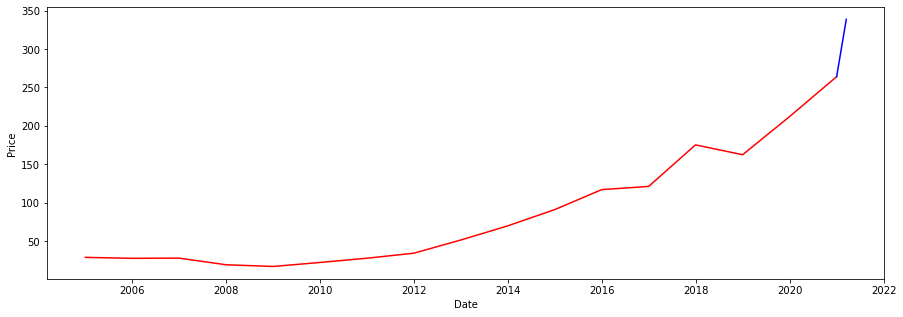

Forecasts (2018-2020):	 [193.75, 237.96, 275.11]
Actual (2018-2020):	 [162.39, 212.02, 263.97]
MAPE:			 11.923882536734114

End of Year Forecast for 2021: $377.3404728452542


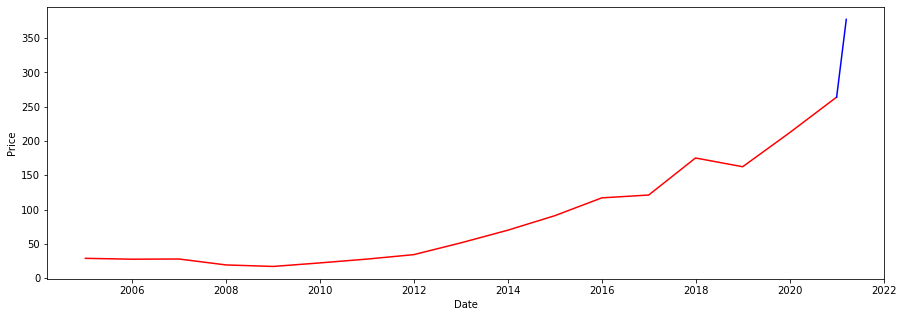

In [22]:
Yearly(2,2,0)
Yearly(5,4,1)

## Forecast based on end of month

In [24]:
HD['Month'] = HD.Date.dt.month
end_month = pd.DataFrame(HD[HD.Date.dt.year == 2004].groupby('Month').last())
for year in sorted(set(HD.Date.dt.year))[1:]:
    end_month = end_month.append(pd.DataFrame(HD[HD.Date.dt.year == year].groupby('Month').last()), sort=False)
end_month = end_month.reset_index(drop = True)
end_month = end_month[['Date','Adj Close']]

end_month.to_csv('monthly_data.csv')


In [25]:
def Monthly(p,d,q):
    testing_model = ARIMA(list(end_month['Adj Close'].values[:-4]), order = (p,d,q)).fit() # 5,9,1 #6,0,1 #6,1,1 #6,2,9 #6,1,9 #2,1,9 #5,1,9
    testing_forecasts = list(testing_model.forecast(steps = 3))
    
    print("order = ", p,",", d,",", q)
    print('Forecasts (Dec 2020 - Feb 2021):\t', [round(x,2) for x in testing_forecasts])
    print('Actual (Dec 2020 - Feb 2021):\t\t', [round(x,2) for x in end_month['Adj Close'].values[-4:-1]])

    MSE_error = mean_absolute_error(end_month['Adj Close'].values[-4:-1], testing_forecasts)
    print('MAPE:\t\t\t\t\t {}'.format(MAPE(list(end_month['Adj Close'].values[-4:-1]), testing_forecasts)))

    # Forecasting End of Month Value for Dec 2021
    forecasts2 = list(testing_model.forecast(steps = 13))
    print('\nEnd of Month Forecast for Dec 2021: ${}'.format(forecasts2[-1]))
    
    
    forecast_dates = [i.date() for i in list(pd.date_range(start = "2020-12-30", 
                                                       end = "2021-12-31"))[1:] 
                  if i.weekday() in [0, 1, 2, 3, 4]]
    i = pd.DataFrame(forecast_dates)
    i['Month'] = [x.month for x in list(i[0])]
    i = i.groupby('Month').last().reset_index(drop = True)
    i['Adj Close'] = forecasts2[1:]

    # Checking Monthly Forecast 
    plt.figure(figsize=(18,5))
    plt.plot(end_month["Date"], end_month["Adj Close"], color = 'red')
    plt.plot(i[0], i['Adj Close'], color = 'blue') # Monthly ARIMA
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()
    
    

In [26]:
#print(auto_arima(end_month['Adj Close'].values[:-4]))
order = auto_arima(end_month['Adj Close'].values).order
order

(0, 2, 2)

order =  0 , 2 , 1
Forecasts (Dec 2020 - Feb 2021):	 [276.94, 279.68, 282.43]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 6.281829208658256

End of Month Forecast for Dec 2021: $309.92070384487175


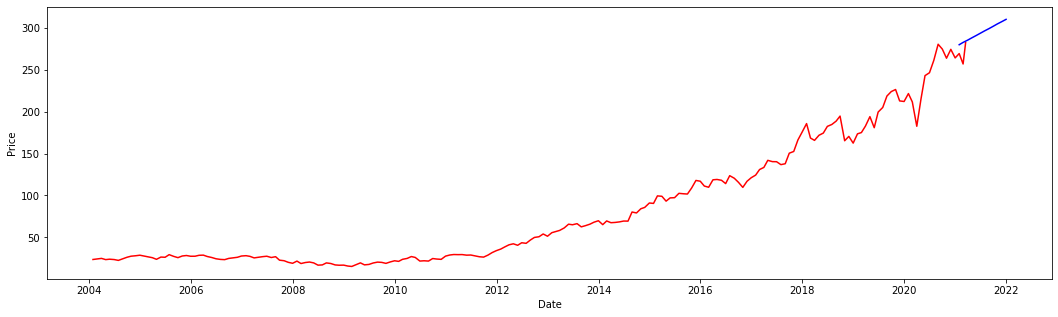



order =  0 , 2 , 2
Forecasts (Dec 2020 - Feb 2021):	 [276.65, 279.47, 282.28]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 6.198811480528144

End of Month Forecast for Dec 2021: $310.39487249191063


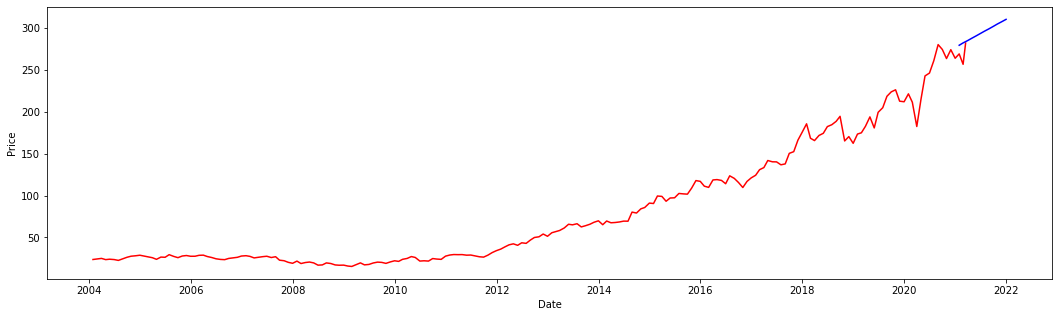



order =  1 , 2 , 1
Forecasts (Dec 2020 - Feb 2021):	 [276.71, 279.51, 282.3]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 6.212897926661251

End of Month Forecast for Dec 2021: $310.21400122098663


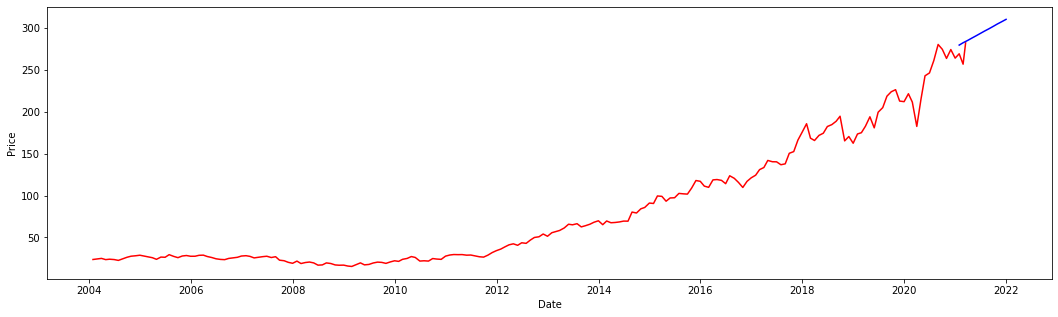



order =  6 , 0 , 1
Forecasts (Dec 2020 - Feb 2021):	 [276.99, 274.59, 273.74]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 4.529039965214255

End of Month Forecast for Dec 2021: $272.1943096666325


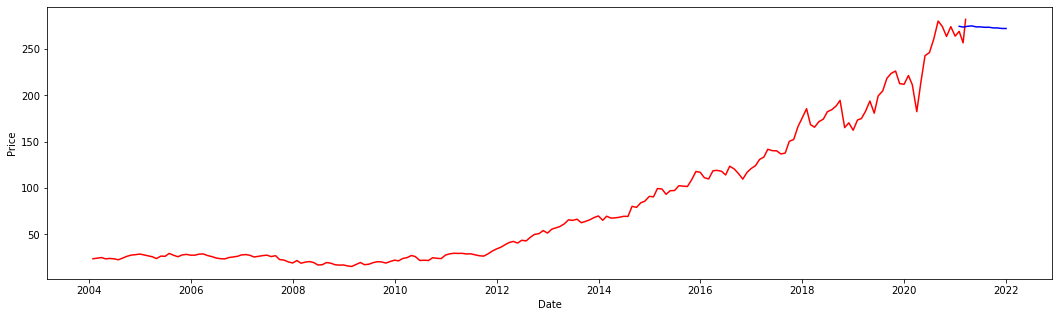



order =  6 , 1 , 1
Forecasts (Dec 2020 - Feb 2021):	 [273.65, 266.23, 264.66]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 2.6113771015992477

End of Month Forecast for Dec 2021: $267.6176541130672


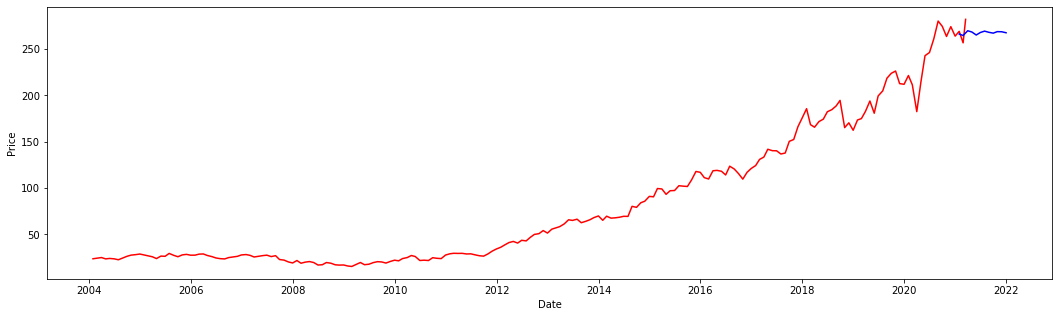



order =  6 , 2 , 9
Forecasts (Dec 2020 - Feb 2021):	 [262.54, 251.7, 264.92]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 3.401808385551916

End of Month Forecast for Dec 2021: $299.44299439618374


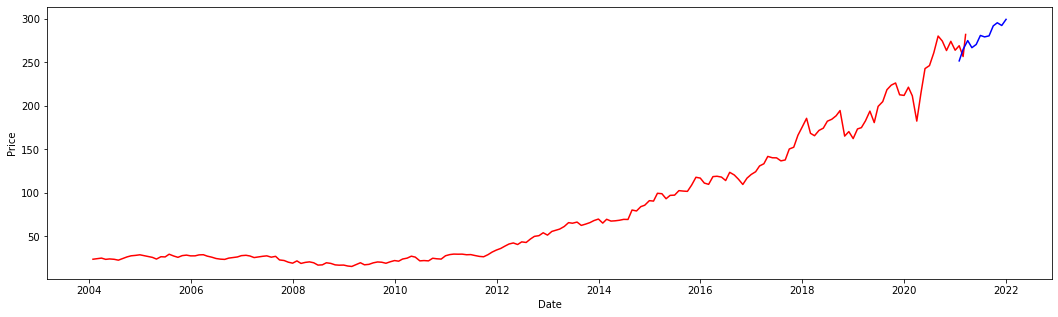



order =  6 , 1 , 9
Forecasts (Dec 2020 - Feb 2021):	 [264.57, 252.23, 265.79]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 3.346969186448538

End of Month Forecast for Dec 2021: $281.18579268115406


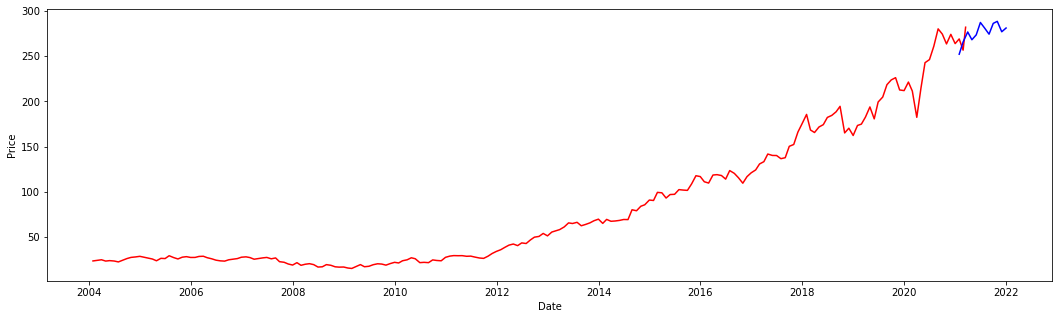



order =  2 , 1 , 9
Forecasts (Dec 2020 - Feb 2021):	 [268.15, 262.01, 268.48]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 2.9365924763568825

End of Month Forecast for Dec 2021: $289.0271587389374


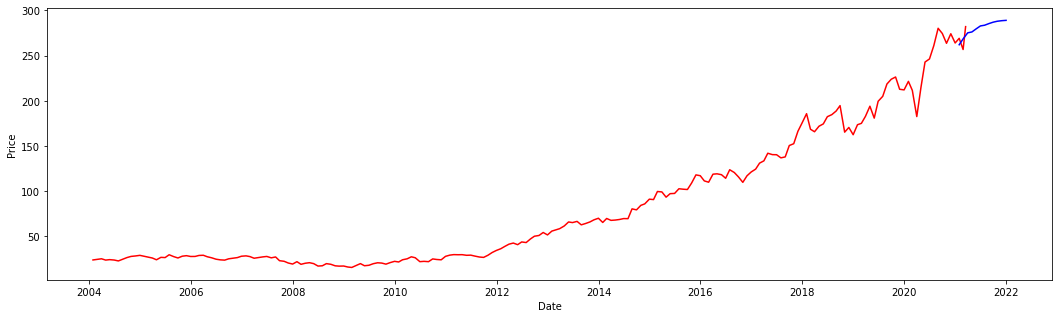



order =  5 , 1 , 9
Forecasts (Dec 2020 - Feb 2021):	 [265.66, 255.36, 264.74]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 2.95899570312611

End of Month Forecast for Dec 2021: $272.25311378616044


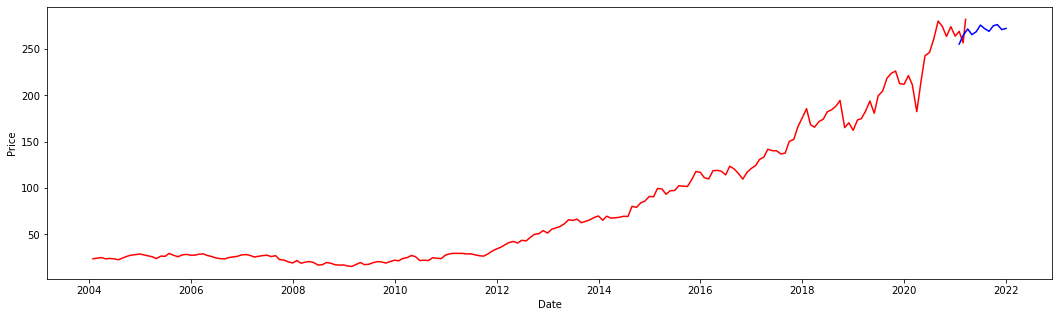

In [27]:
# Auto ARIMA
Monthly(0,2,1)
print("\n")

# All others
Monthly(0,2,2)
print("\n")
Monthly(1,2,1)
print("\n")
Monthly(6,0,1) #used
print("\n")
Monthly(6,1,1)
print("\n")
Monthly(6,2,9)
print("\n")
Monthly(6,1,9)
print("\n")
Monthly(2,1,9)
print("\n")
Monthly(5,1,9)


## Forecast based on end of quarter

In [28]:
Quarters = []
for m in HD.Month:
    if m in [1, 2, 3]:
        Quarters.append('Quarter 1')
    elif m in [4, 5, 6]:
        Quarters.append('Quarter 2')
    elif m in [7, 8, 9]:
        Quarters.append('Quarter 3')
    elif m in [10, 11, 12]:
        Quarters.append('Quarter 4')
HD['Quarter'] = Quarters
HD['Year'] = HD.Date.dt.year

In [29]:
quarter = HD.groupby(['Year', 'Quarter']).last()
quarter.to_csv('quarterly_data.csv')

In [30]:
def Quarterly(p,d,q):
    testing_model = ARIMA(list(quarter['Adj Close'].values[:-4]), order = (p,d,q)).fit() #8,2,10
    testing_forecasts = list(testing_model.forecast(steps = 3))
    print('Forecasts (Dec 2020 - Feb 2021):\t', [round(x,2) for x in testing_forecasts])
    print('Actual (Dec 2020 - Feb 2021):\t\t', [round(x,2) for x in end_month['Adj Close'].values[-4:-1]])

    MSE_error = mean_absolute_error(end_month['Adj Close'].values[-4:-1], testing_forecasts)
    print('MAPE:\t\t\t\t\t {}'.format(MAPE(list(end_month['Adj Close'].values[-4:-1]), testing_forecasts)))

    # Forecasting End of Month Value for Dec 2021
    forecasts2 = list(testing_model.forecast(steps = 13))
    print('\nEnd of Month Forecast for Dec 2021: ${}'.format(forecasts2[-1]))

    forecast_dates = [i.date() for i in list(pd.date_range(start = "2020-12-30", 
                                                       end = "2021-12-31"))[1:] 
                  if i.weekday() in [0, 1, 2, 3, 4]]

    i = pd.DataFrame(forecast_dates)
    i['Quarter'] = [x.month for x in list(i[0])]
    i = i.groupby('Quarter').last().reset_index(drop = True)
    i['Adj Close'] = forecasts2[1:]

    forecast_dates = [i.date() for i in list(pd.date_range(start = "2020-12-30", 
                                                           end = "2021-12-31"))[1:] 
                      if i.weekday() in [0, 1, 2, 3, 4]]

    # Checking Monthly Forecast 
    plt.figure(figsize=(18,5))
    plt.plot(quarter["Date"], quarter["Adj Close"], color = 'red')
    plt.plot(i[0], i['Adj Close'], color = 'blue') # quarterly ARIMA
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

In [31]:
auto_arima(quarter['Adj Close'].values)

ARIMA(order=(0, 2, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Forecasts (Dec 2020 - Feb 2021):	 [193.33, 196.96, 200.58]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 25.14965787824715

End of Month Forecast for Dec 2021: $236.80491226552152


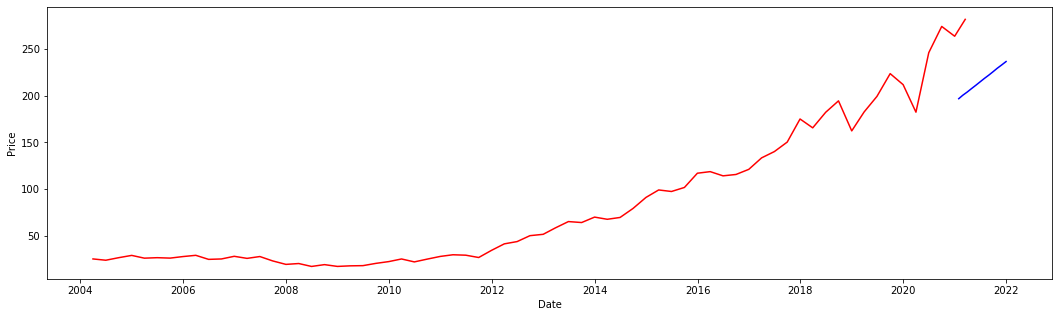



Forecasts (Dec 2020 - Feb 2021):	 [236.39, 244.97, 223.56]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 10.781419122234386

End of Month Forecast for Dec 2021: $294.33247934717997


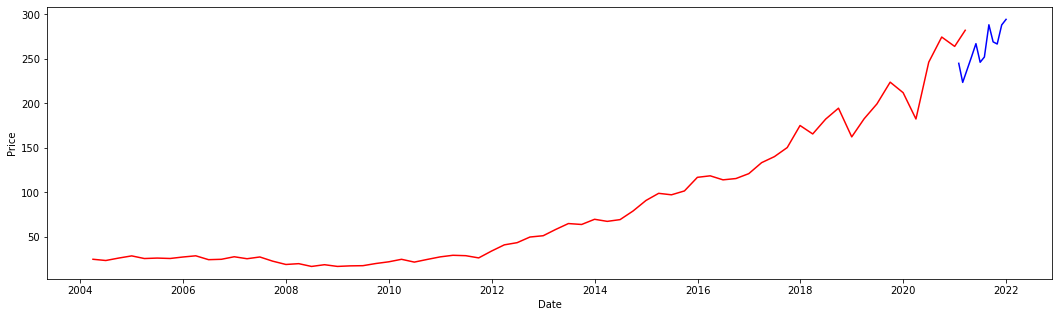



Forecasts (Dec 2020 - Feb 2021):	 [237.15, 251.54, 228.72]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 9.201501548569778

End of Month Forecast for Dec 2021: $302.9251612100422


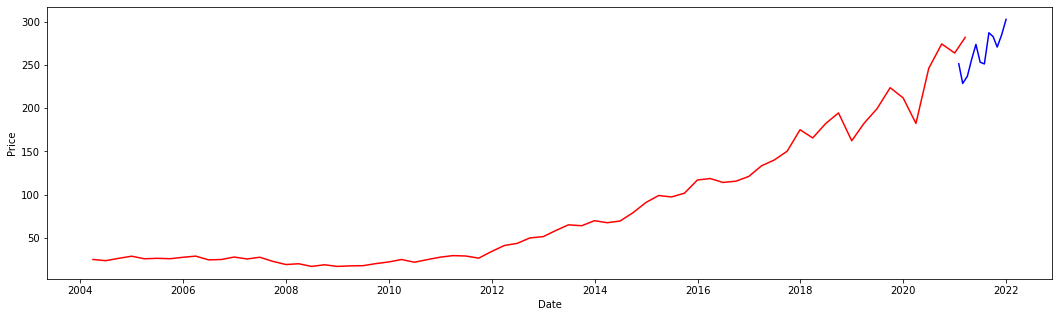



Forecasts (Dec 2020 - Feb 2021):	 [249.35, 273.96, 244.46]
Actual (Dec 2020 - Feb 2021):		 [263.97, 269.13, 256.73]
MAPE:					 4.035668138158063

End of Month Forecast for Dec 2021: $320.6152723178855


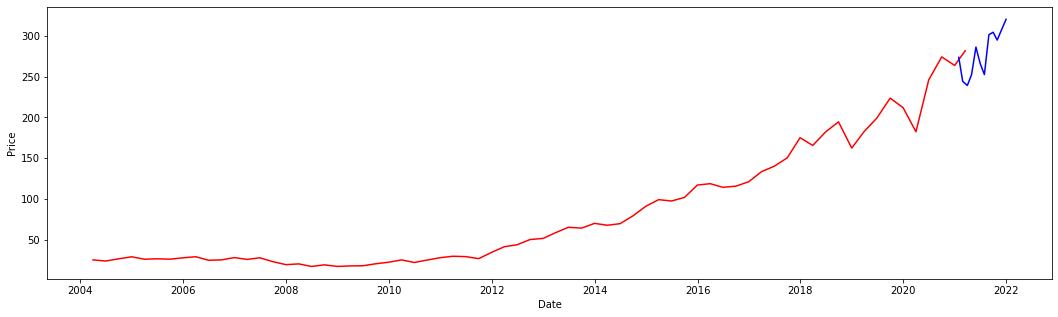

In [32]:
# Auto ARIMA
Quarterly(0,2,2)
print("\n")

# All others
Quarterly(6,2,6) # used
print("\n")
Quarterly(7,2,6)
print("\n")
Quarterly(8,2,10)
print("\n")